Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
9826
(10, 100, 28, 28, 1)
4/4 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 1.0000


4/4 [==============================] - 0s 3ms/step - loss: 0.0055 - accuracy: 1.0000


4/4 [==============================] - 0s 3ms/step - loss: 0.0057 - accuracy: 1.0000


4/4 [==============================] - 0s 4ms/step - loss: 0.0241 - accuracy: 0.9900


4/4 [==============================] - 0s 4ms/step - loss: 0.0807 - accuracy: 0.9700


4/4 [==============================] - 0s 3ms/step - loss: 0.1413 - accuracy: 0.9400


4/4 [==============================] - 0s 3ms/step - loss: 0.2126 - accuracy: 0.9200


4/4 [==============================] - 0s 4ms/step - loss: 0.2719 - accuracy: 0.9000


4/4 [==============================] - 0s 4ms/step - loss: 0.5571 - accuracy: 0.8300


4/4 [==============================] - 0s 3ms/step - loss: 0.4759 - accuracy: 0.8700


4/4 [==============================] - 0s 7ms/step - loss: 0.9461 - accuracy: 0.7700


4/4 [==============================] - 0s 4ms/step - loss: 0.8636 - accuracy: 0.7800


4/4 [==============================] - 0s 4ms/step - loss: 1.3790 - accuracy: 0.7000


4/4 [==============================] - 0s 4ms/step - loss: 1.3033 - accuracy: 0.7100


4/4 [==============================] - 0s 4ms/step - loss: 1.7319 - accuracy: 0.6400


4/4 [==============================] - 0s 3ms/step - loss: 1.6091 - accuracy: 0.6200


4/4 [==============================] - 0s 3ms/step - loss: 2.2676 - accuracy: 0.5500


4/4 [==============================] - 0s 4ms/step - loss: 2.1723 - accuracy: 0.5300


4/4 [==============================] - 0s 3ms/step - loss: 2.7699 - accuracy: 0.5100


4/4 [==============================] - 0s 3ms/step - loss: 2.7506 - accuracy: 0.5300


4/4 [==============================] - 0s 3ms/step - loss: 3.0967 - accuracy: 0.5100


4/4 [==============================] - 0s 3ms/step - loss: 3.0605 - accuracy: 0.5100


4/4 [==============================] - 0s 6ms/step - loss: 3.3891 - accuracy: 0.4900


4/4 [==============================] - 0s 4ms/step - loss: 3.3140 - accuracy: 0.4700


4/4 [==============================] - 0s 4ms/step - loss: 3.5922 - accuracy: 0.4300


4/4 [==============================] - 0s 5ms/step - loss: 3.8201 - accuracy: 0.4000


4/4 [==============================] - 0s 4ms/step - loss: 3.8792 - accuracy: 0.4000


4/4 [==============================] - 0s 6ms/step - loss: 4.0982 - accuracy: 0.3600


4/4 [==============================] - 0s 4ms/step - loss: 4.1831 - accuracy: 0.3800


4/4 [==============================] - 0s 6ms/step - loss: 4.2667 - accuracy: 0.3900


4/4 [==============================] - 0s 5ms/step - loss: 4.3651 - accuracy: 0.3900


4/4 [==============================] - 0s 3ms/step - loss: 4.4765 - accuracy: 0.3300


4/4 [==============================] - 0s 3ms/step - loss: 4.6222 - accuracy: 0.3500


4/4 [==============================] - 0s 4ms/step - loss: 4.6878 - accuracy: 0.3200


4/4 [==============================] - 0s 3ms/step - loss: 4.5378 - accuracy: 0.3600


4/4 [==============================] - 0s 4ms/step - loss: 5.0281 - accuracy: 0.2800


4/4 [==============================] - 0s 3ms/step - loss: 4.7165 - accuracy: 0.3300


4/4 [==============================] - 0s 4ms/step - loss: 5.2418 - accuracy: 0.2700


4/4 [==============================] - 0s 4ms/step - loss: 4.8943 - accuracy: 0.3100


4/4 [==============================] - 0s 4ms/step - loss: 5.0994 - accuracy: 0.2900


4/4 [==============================] - 0s 3ms/step - loss: 5.1268 - accuracy: 0.2800


4/4 [==============================] - 0s 3ms/step - loss: 5.3971 - accuracy: 0.2800
[array([ 0.0625, -0.0625, -0.0625,  0.0625, -0.0625,  0.0625,  0.0625,
        0.0625,  0.0625, -0.0625,  0.0625,  0.0625,  0.0625,  0.0625,
        0.0625, -0.0625,  0.0625, -0.0625, -0.0625,  0.0625, -0.0625,
       -0.0625,  0.0625, -0.0625,  0.0625, -0.0625,  0.0625,  0.0625,
       -0.0625,  0.0625,  0.0625, -0.0625, -0.0625,  0.0625,  0.0625,
        0.0625, -0.0625, -0.0625, -0.0625, -0.0625, -0.0625,  0.0625,
        0.0625, -0.0625,  0.0625, -0.0625,  0.0625,  0.0625,  0.0625,
        0.0625, -0.0625, -0.0625, -0.0625, -0.0625,  0.0625,  0.0625,
       -0.0625, -0.0625,  0.0625, -0.0625, -0.0625, -0.0625,  0.0625,
       -0.0625,  0.0625, -0.0625,  0.0625,  0.0625,  0.0625, -0.0625,
        0.0625, -0.0625, -0.0625, -0.0625, -0.0625, -0.0625,  0.0625,
        0.0625, -0.0625,  0.0625, -0.0625, -0.0625, -0.0625,  0.0625,
        0.0625,  0.0625, -0.0625, -0.0625, -0.0625,  0.0625,  0.0625,
    

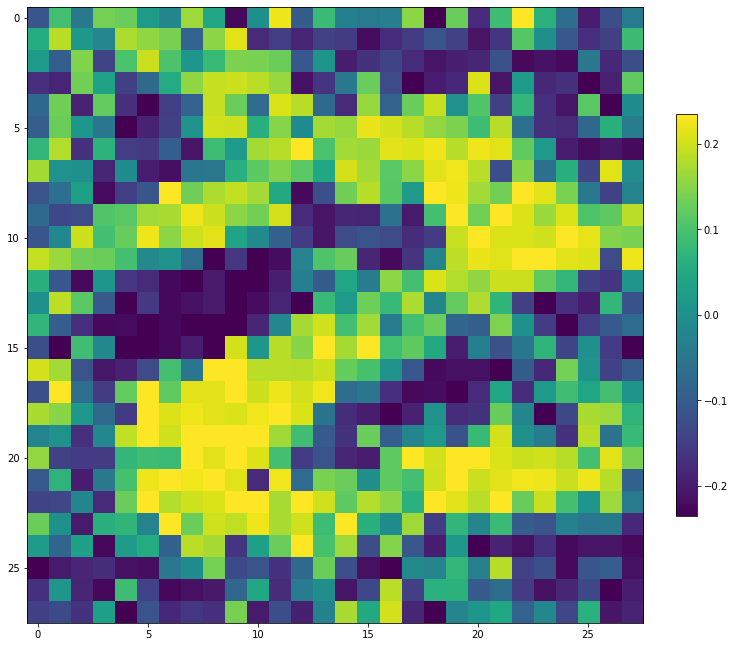

In [1]:
from algorithms import *
from lenet5 import *
import numpy as np
import matplotlib.pyplot as plt

_, (test_x, test_y) = load_MNIST()

path = './data/lenet5'

lenet5 = LeNet5(path=path, load=True)

epsilon = 0.25
d = 28*28

lab = lenet5.predict(test_x)
indexes = lab == test_y
data = test_x[indexes]
labels = test_y[indexes]

print(len(labels))  # 9826

# M = num workers; we consider a number of workers <=10
M = 10
data_per_classes = []
for label_class in range(0, 10):
    data_per_classes.append(data[labels == label_class][:100])

data_per_classes = np.array(data_per_classes)
data_workers = []

for offset in range(0, 100, M):
    image_worker = []
    for c in range(0, 10):
        image_worker.extend(data_per_classes[c, offset:offset+M, :, :, :])
    data_workers.append(image_worker)

data_workers = np.array(data_workers)
print(data_workers.shape)  # now all 10 workers have 100 images, 10 for each class.

y = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.repeat(y, 10)

m = 20
T = 20
delta = decentralized_stochastic_gradient_free_FW(data_workers, y, lenet5.negative_loss, m, T, M, epsilon, d)
print(delta)

fig, ax = plt.subplots(figsize=(12, 12))
img = plt.imshow(delta[-1].reshape((28, 28)))
fig.colorbar(img, ax=ax, fraction=0.03, pad=0.05)
plt.savefig(f"./perturbation_{m}", bbox_inches="tight")
plt.show()

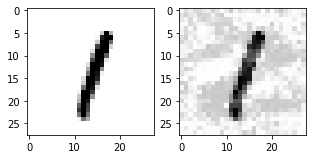

[2]


In [42]:
image = test_x[5].numpy().reshape(28,28)
img_noise = image + delta[-1].reshape((28, 28))
fig, ax = plt.subplots(1, 2,figsize=(5, 5))
ax[0].imshow(image, cmap='Greys')
ax[1].imshow(img_noise, cmap='Greys')
plt.savefig(f"./image_perturbation_example_{m}", bbox_inches="tight")
plt.show()
print(lenet5.predict(np.array([img_noise.reshape(28, 28 ,1)])))